<img src="images/ppi-animation.gif" width=600 alt="TRACER Animation"></img>
# Plotting Data from a Field Campaign (TRACER)

## Overview

Within this notebook, we will cover:

1. How to access data from the Atmospheric Radiation Measurment (ARM) user facility
1. How to setup a workflow to plot both cross sections (RHIs) and horizontal scans (PPIs)

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Required | Basic plotting |
| [Py-ART Basics](../foundations/pyart-basics) | Required | IO/Visualization |

---
## Imports

In [2]:
import glob
import os
from pathlib import Path

import act
import imageio.v2 as imageio
import matplotlib
import matplotlib.pyplot as plt
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/Users/mgrover/miniforge3/envs/pyart-docs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Grab Data from ARM

One of the better cases was from June 2, 2022, where several cold pools and single-cell storms traversed through the domain.

### The Tracking Aerosol Convection Interactions ExpeRiment (TRACER) Field Campaign

Data is available from the Atmospheric Radiation Measurment user facility, which helped to lead the TRACER field campaign in Houston, Texas.

The data are available from the ARM data portal (https://adc.arm.gov/).

We are interested in the C-band radar, which is utilizing a cell-tracking algorithm, with the datastream
* **`houcsapr2cfrS2.a1`**

### Use the ARM Live API to Download the Data, using ACT

The Atmospheric Data Community Toolkit (ACT) has a helpful module to interface with the data server:
* [Download Data API](https://arm-doe.github.io/ACT/API/generated/act.discovery.download_data.html#act.discovery.download_data)

In [3]:
act.discovery.download_data?

Signature:
act.discovery.download_data(
    username,
    token,
    datastream,
    startdate,
    enddate,
    time=None,
    output=None,
)
Docstring:
This tool will help users utilize the ARM Live Data Webservice to download
ARM data.

Parameters
----------
username : str
    The username to use for logging into the ADC archive.
token : str
    The access token for accessing the ADC archive.
datastream : str
    The name of the datastream to acquire.
startdate : str
    The start date of the data to acquire. Formats accepted are
    YYYY-MM-DD, DD.MM.YYYY, DD/MM/YYYY, YYYYMMDD, YYYY/MM/DD or
    any of the previous formats with THH:MM:SS added onto the end
    (ex. 2020-09-15T12:00:00).
enddate : str
    The end date of the data to acquire. Formats accepted are
    YYYY-MM-DD, DD.MM.YYYY, DD/MM/YYYY, YYYYMMDD or YYYY/MM/DD, or
    any of the previous formats with THH:MM:SS added onto the end
    (ex. 2020-09-15T13:00:00).
time: str or None
    The specific time. Format is HHMMSS. S

### Setup our Download Query
Before downloading our data, we need to make sure we have an ARM Data Account, and ARM Live token. Both of these can be found using this link:
- [ARM Live Signup](https://adc.arm.gov/armlive/livedata/home)

Once you sign up, you will see your token. Copy and replace that where we have `arm_username` and `arm_password` below.

In [9]:
arm_username = os.getenv("ARM_USERNAME")
arm_password = os.getenv("ARM_PASSWORD")

datastream = "houcsapr2cfrS2.a1"

start_date = "2022-06-17T19:00:00"
end_date = "2022-06-17T19:05:00"

print(len(arm_username), len(arm_password))

8 16


In [10]:
csapr_files = act.discovery.download_data(arm_username,
                                          arm_password,
                                          datastream,
                                          start_date,
                                          end_date)

[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190219.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190312.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190448.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190237.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190154.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190027.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190001.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190057.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190145.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190106.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190325.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190246.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190358.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190414.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190041.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190132.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190334.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220617.190424.nc


In [3]:
csapr_files = sorted(glob.glob('houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220617.19*'))

## Read in and Plot the Data
Before following running the next cells, make sure you have created the following directories:
- `quicklooks/ppi`
- `quicklooks/rhi`
- `quicklooks/vpt`

In [12]:
!mkdir quicklooks
!mkdir quicklooks/rhi
!mkdir quicklooks/ppi
!mkdir quicklooks/vpt

mkdir: quicklooks: File exists
mkdir: quicklooks/rhi: File exists
mkdir: quicklooks/ppi: File exists
mkdir: quicklooks/vpt: File exists


### Loop through and plot
We read in the data, check the scan type, and plot a basic `RadarDisplay` which will automatically detect whether the plot is a vertical cross section (RHI or VPT), or a horizontal scan (PPI).

This offers a solid "quick look", or initial visualization of the data.

ppi


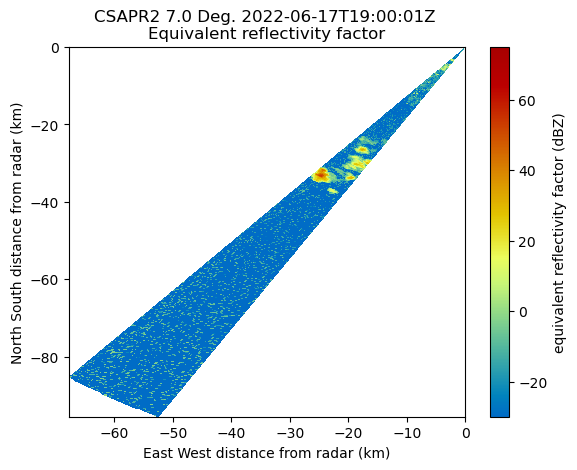

rhi


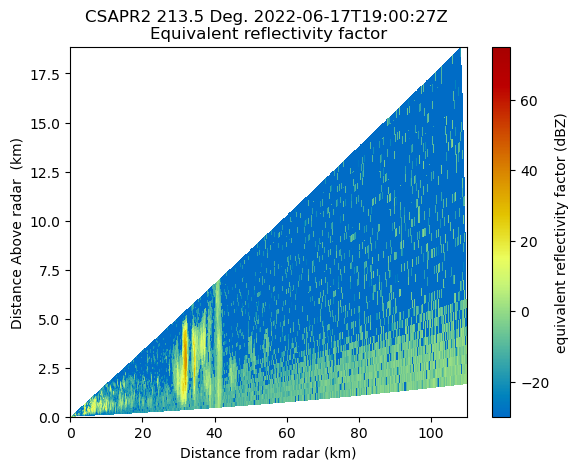

rhi


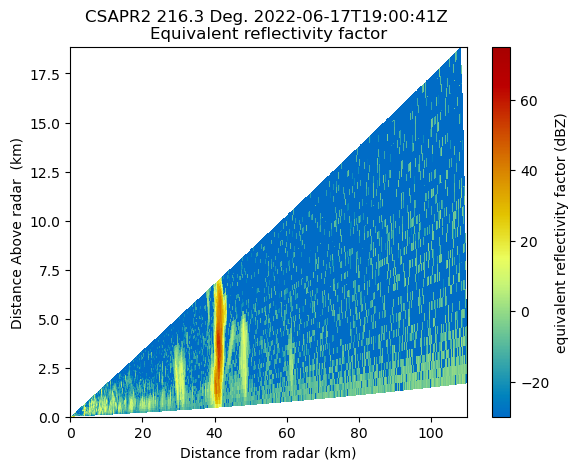

rhi


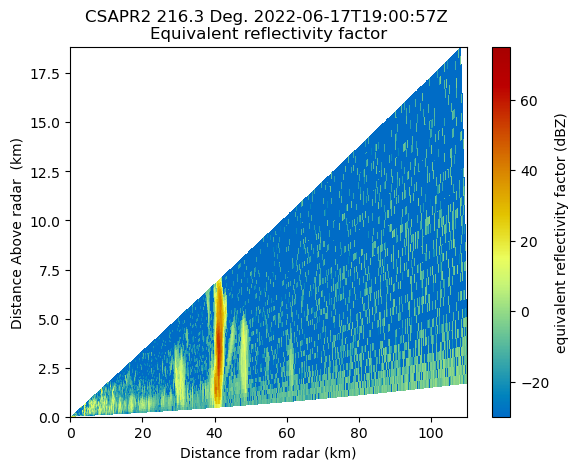

ppi


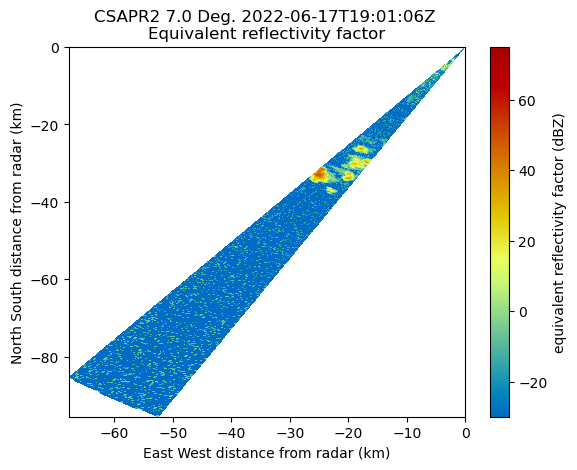

rhi


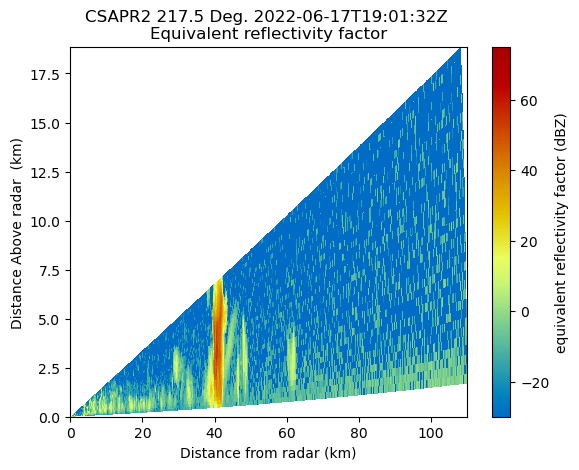

rhi


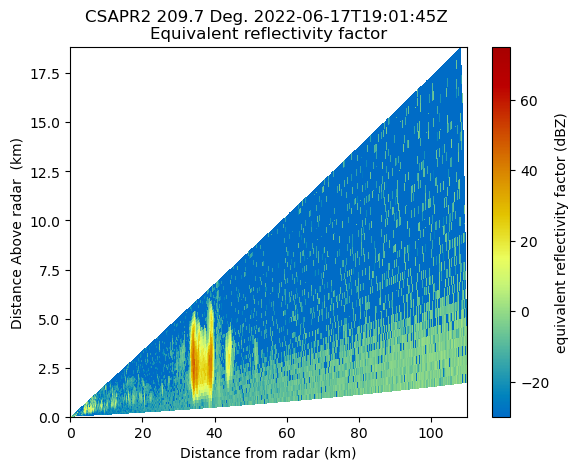

ppi


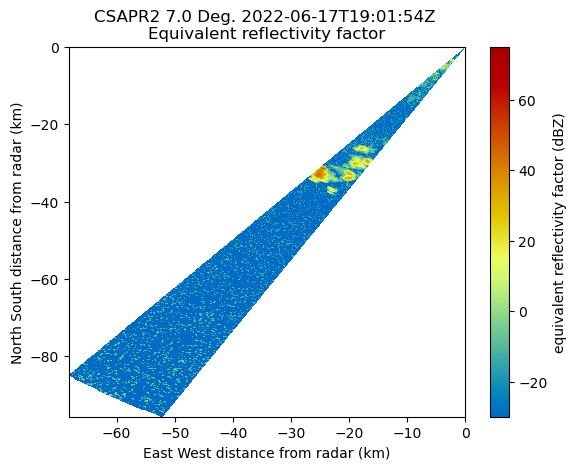

rhi


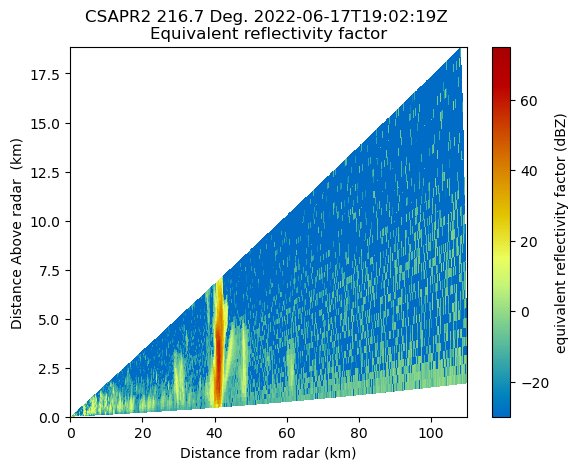

rhi


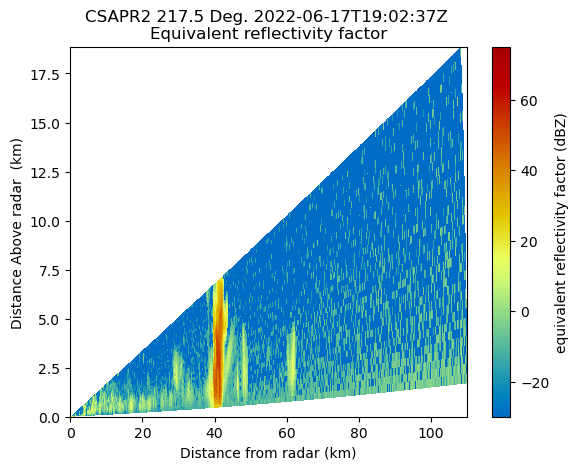

ppi


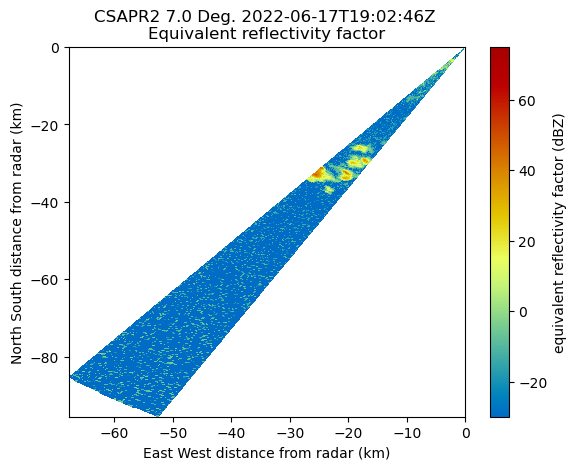

rhi


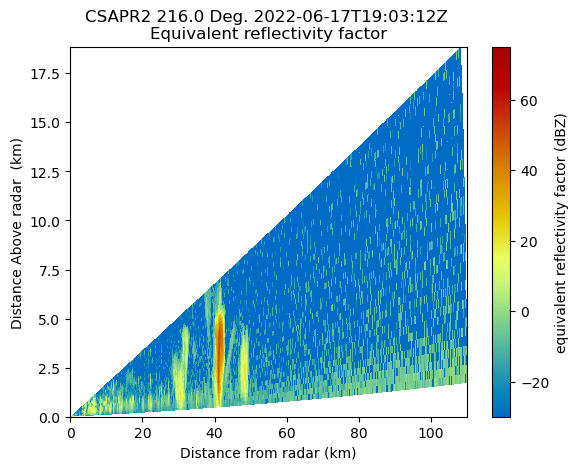

rhi


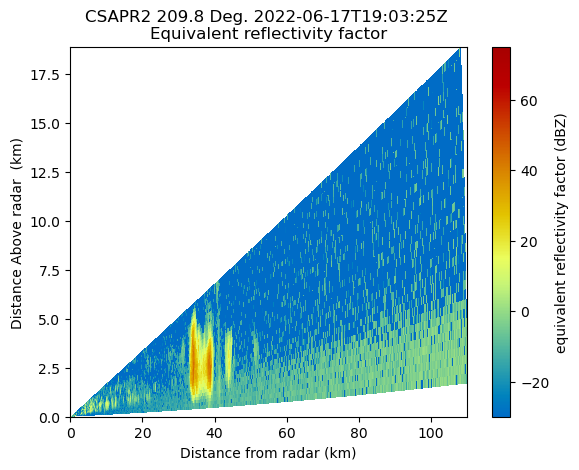

ppi


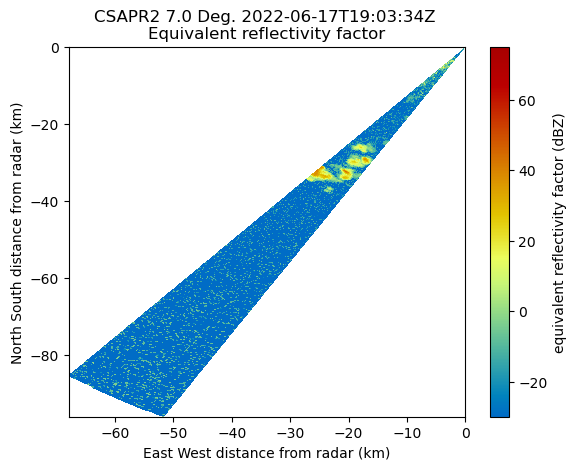

rhi


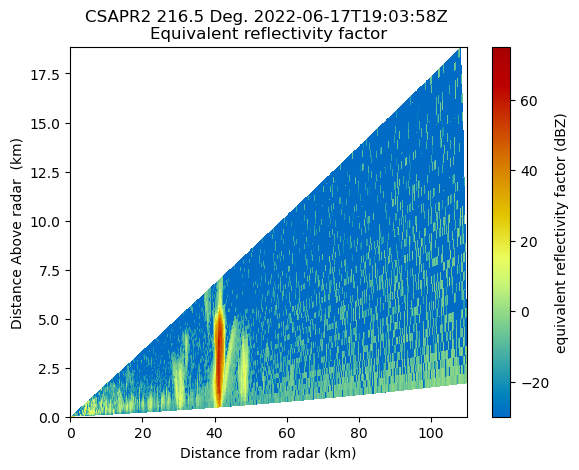

rhi


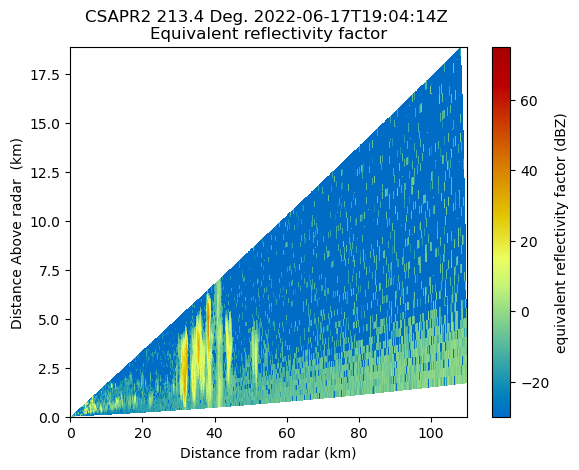

ppi


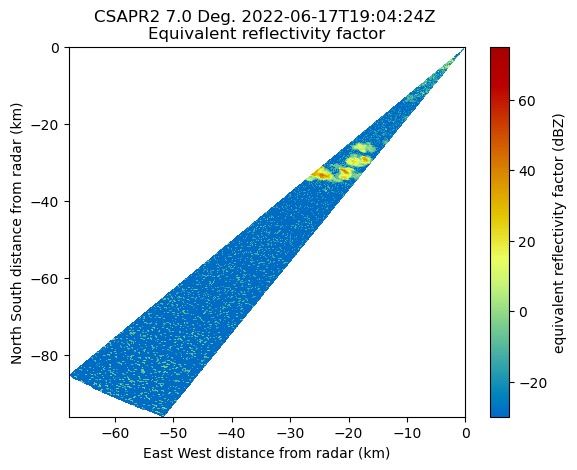

rhi


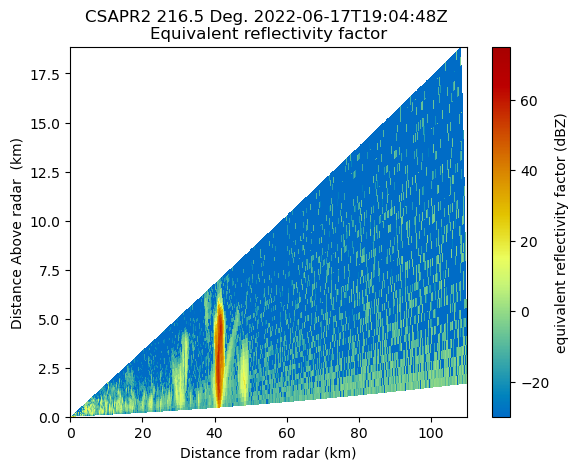

In [13]:
for file in csapr_files:
    radar = pyart.io.read(file)
    print(radar.scan_type)
    display = pyart.graph.RadarDisplay(radar)
    display.plot("reflectivity", 0)
    plt.savefig(f"quicklooks/{radar.scan_type}/{Path(file).stem}.png", dpi=200)
    plt.show()
    plt.close() 

### Refine our Plot, Plot Velocity
Let's focus on the vertical scans of the data, or the RHIs.

You'll notice that we had some cells around 60 km from the radar, with the vertical axis less than 6 km.

Let's reflect that in the plots!

#### Customize our plot look
Before we plot, we can change the size of our font, and style using the following parameters:

In [11]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

xlim_dict = {'ppi':(-30, -10),
             'rhi':(36, 46)
            }

ylim_dict = {'ppi':(-45, -25),
             'rhi':(0, 10)
            }

#### Apply our Plotting Loop
We:
- Check to see if the scan is an RHI
- Plot the reflectivity on one subplot
- Plot velocity on the other
- Save our plots

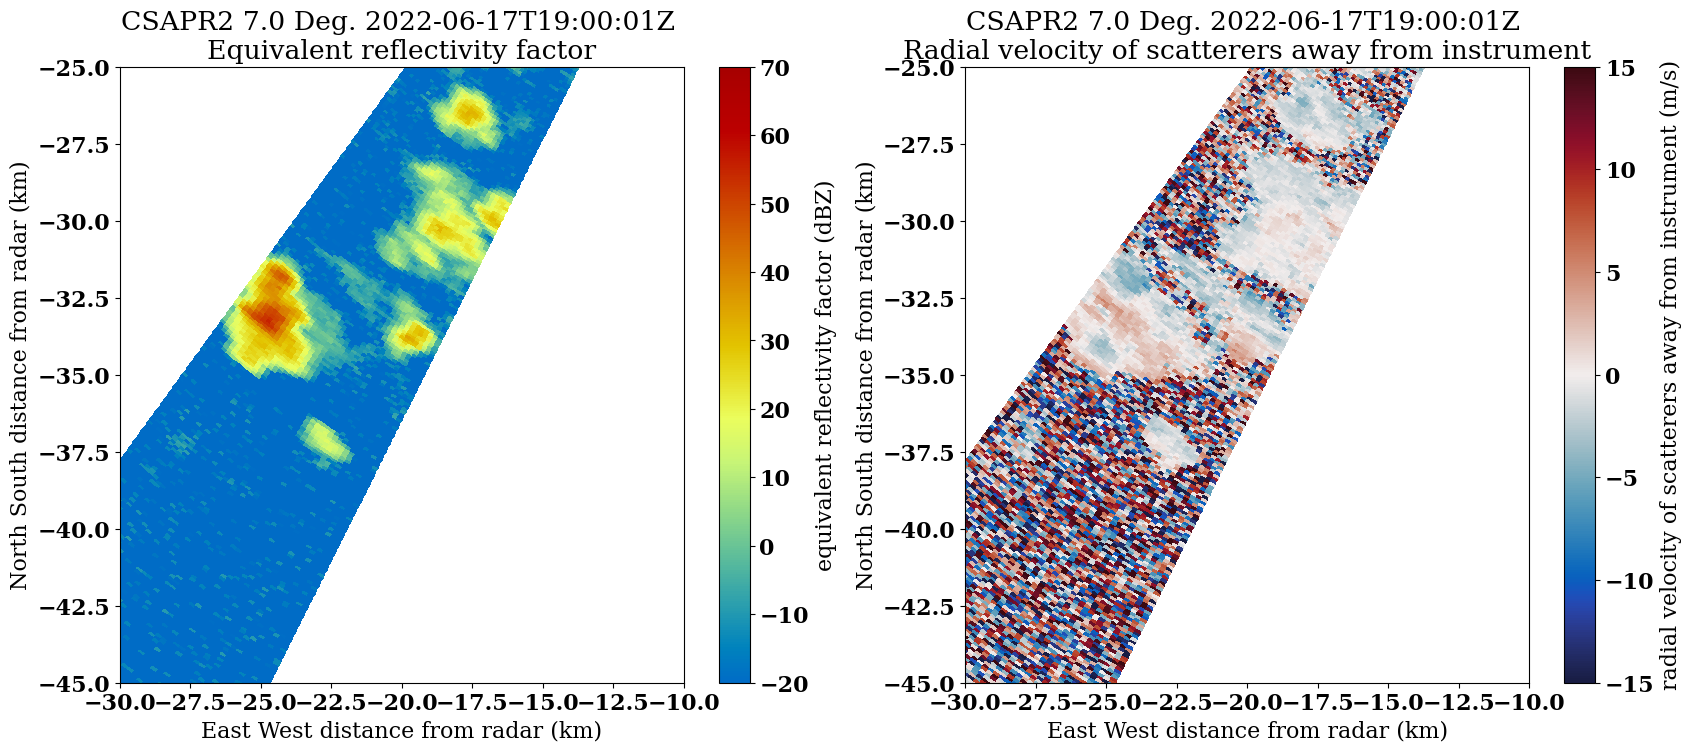

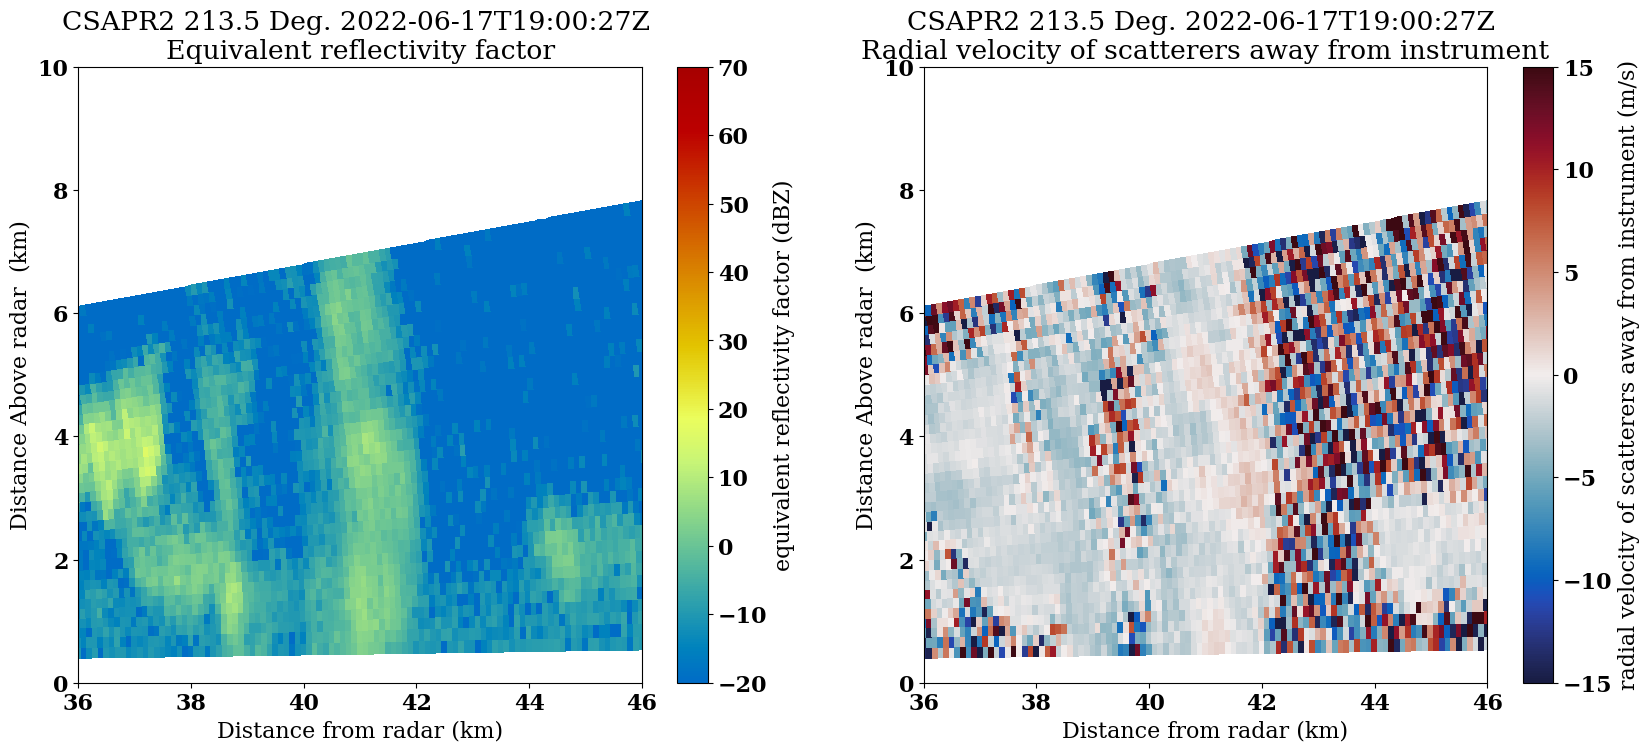

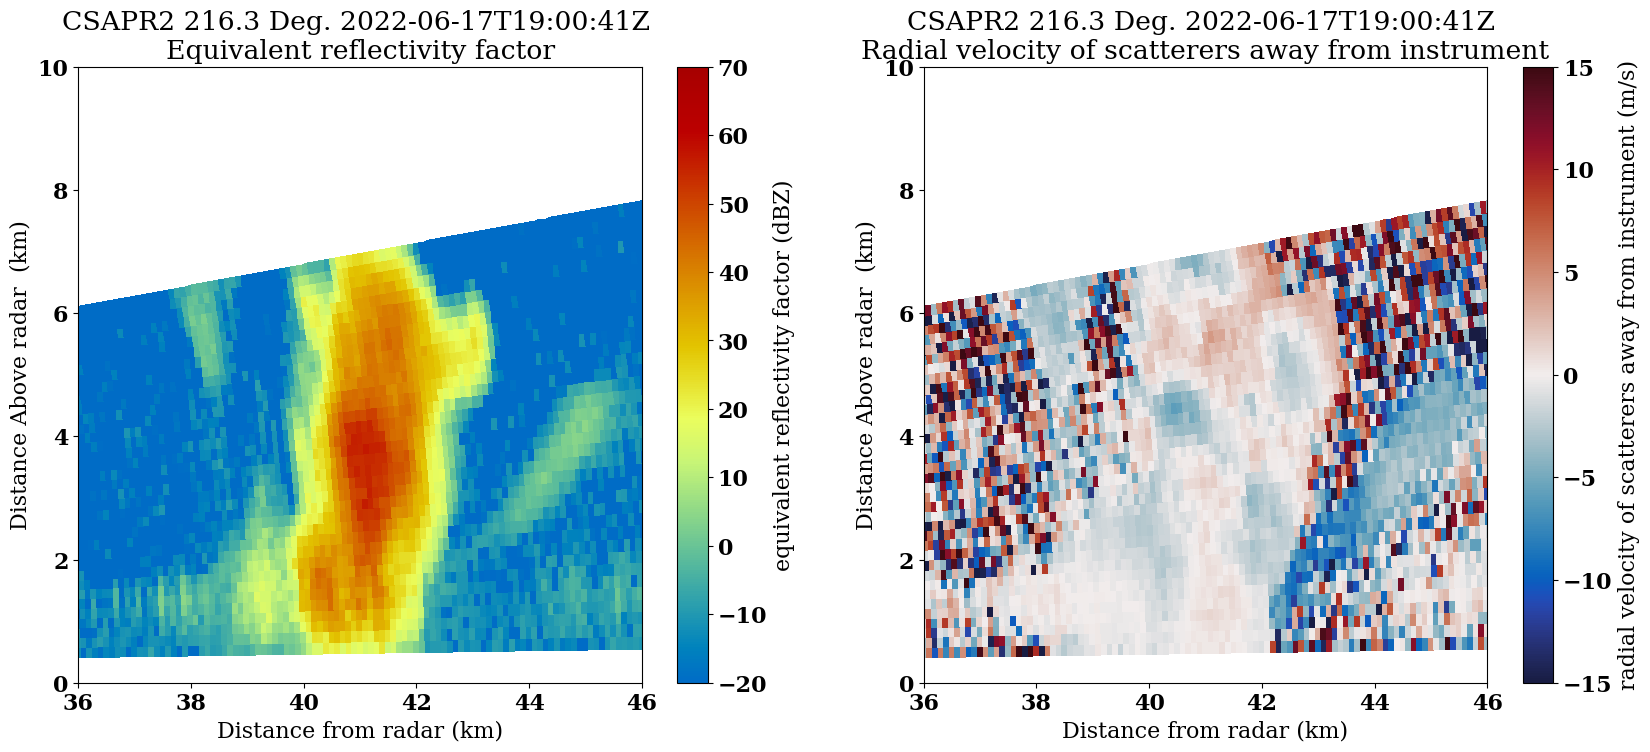

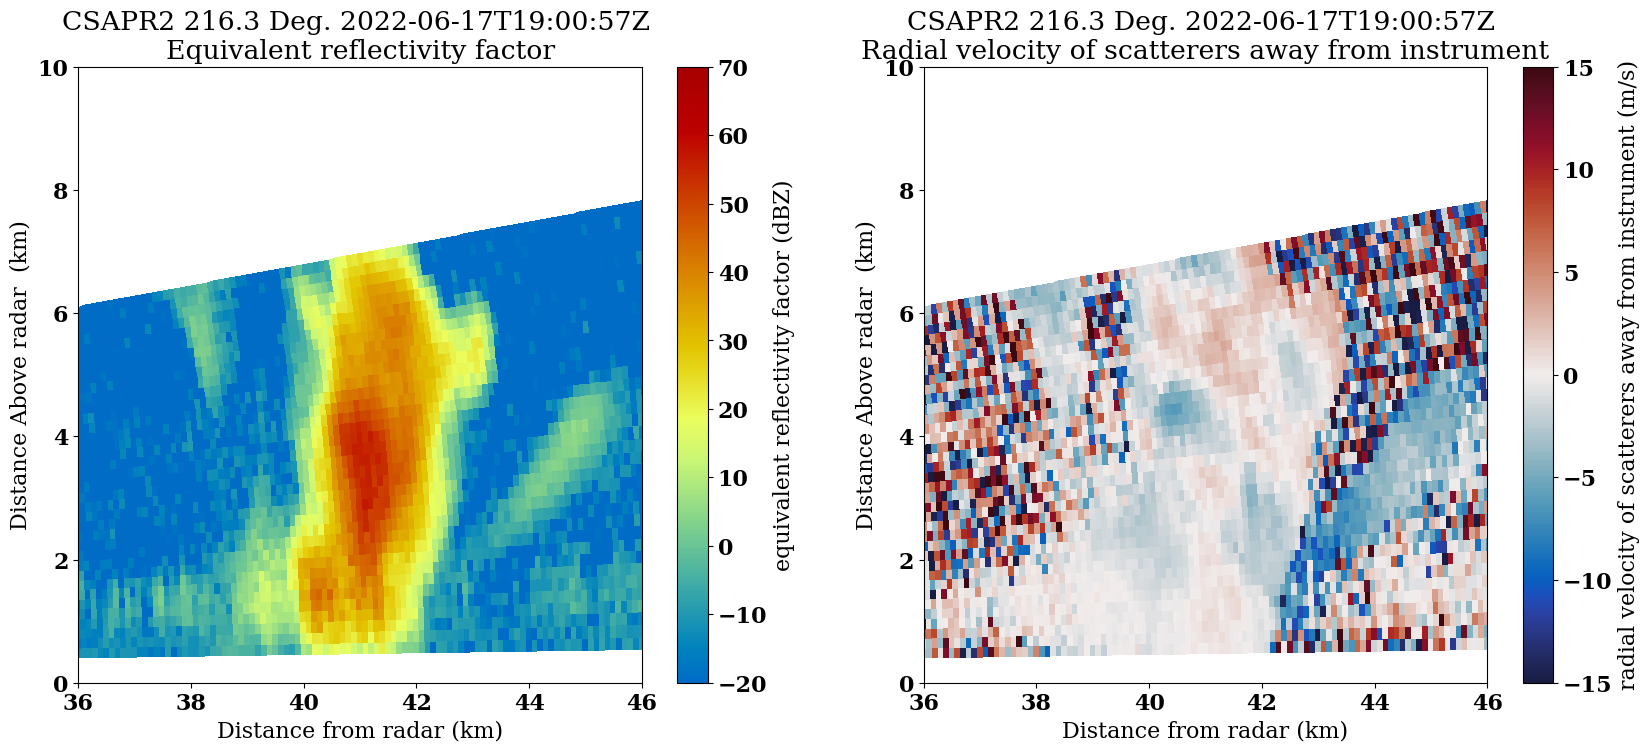

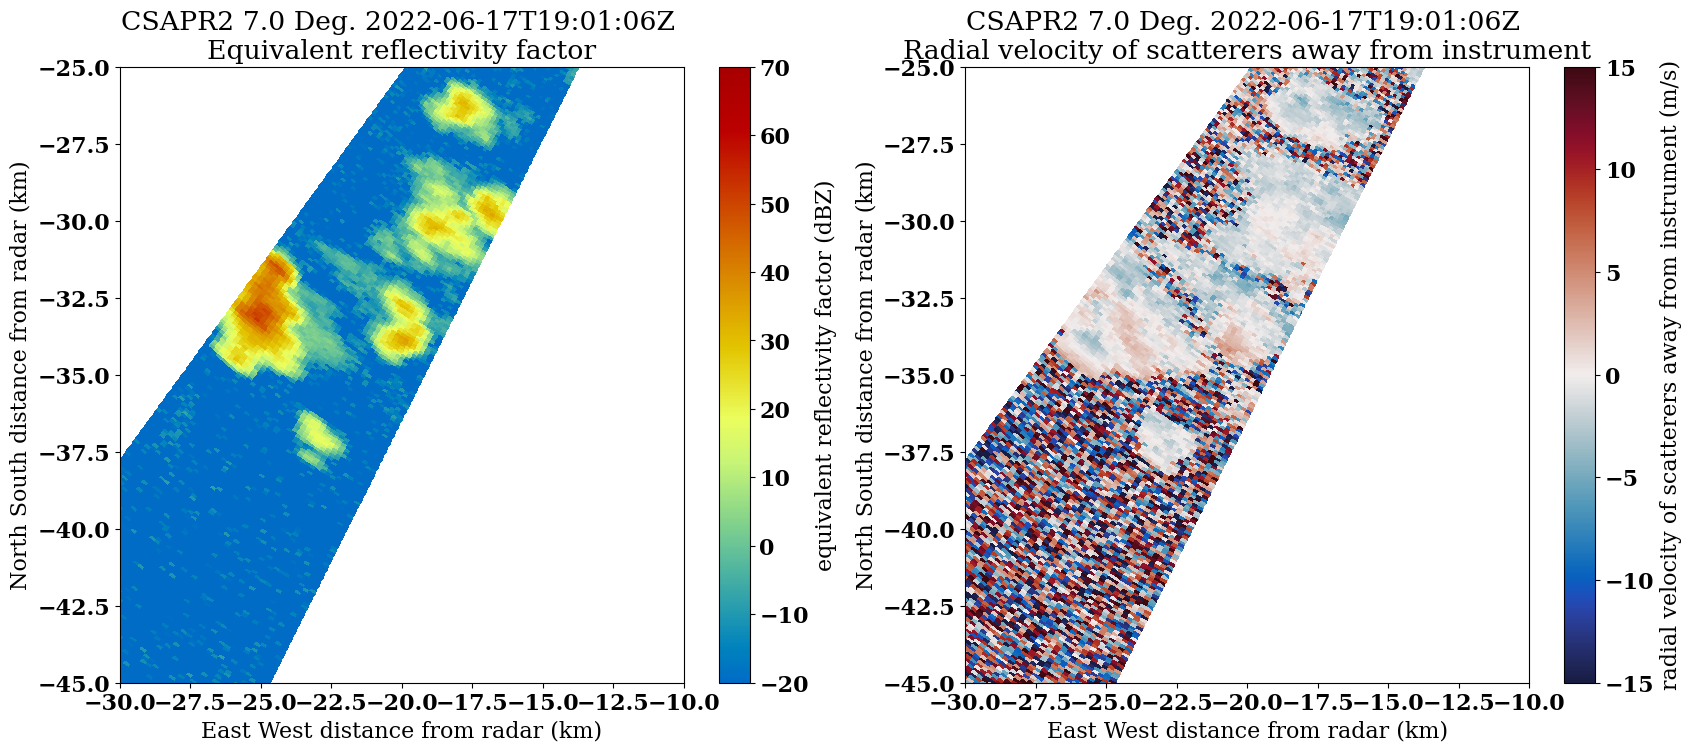

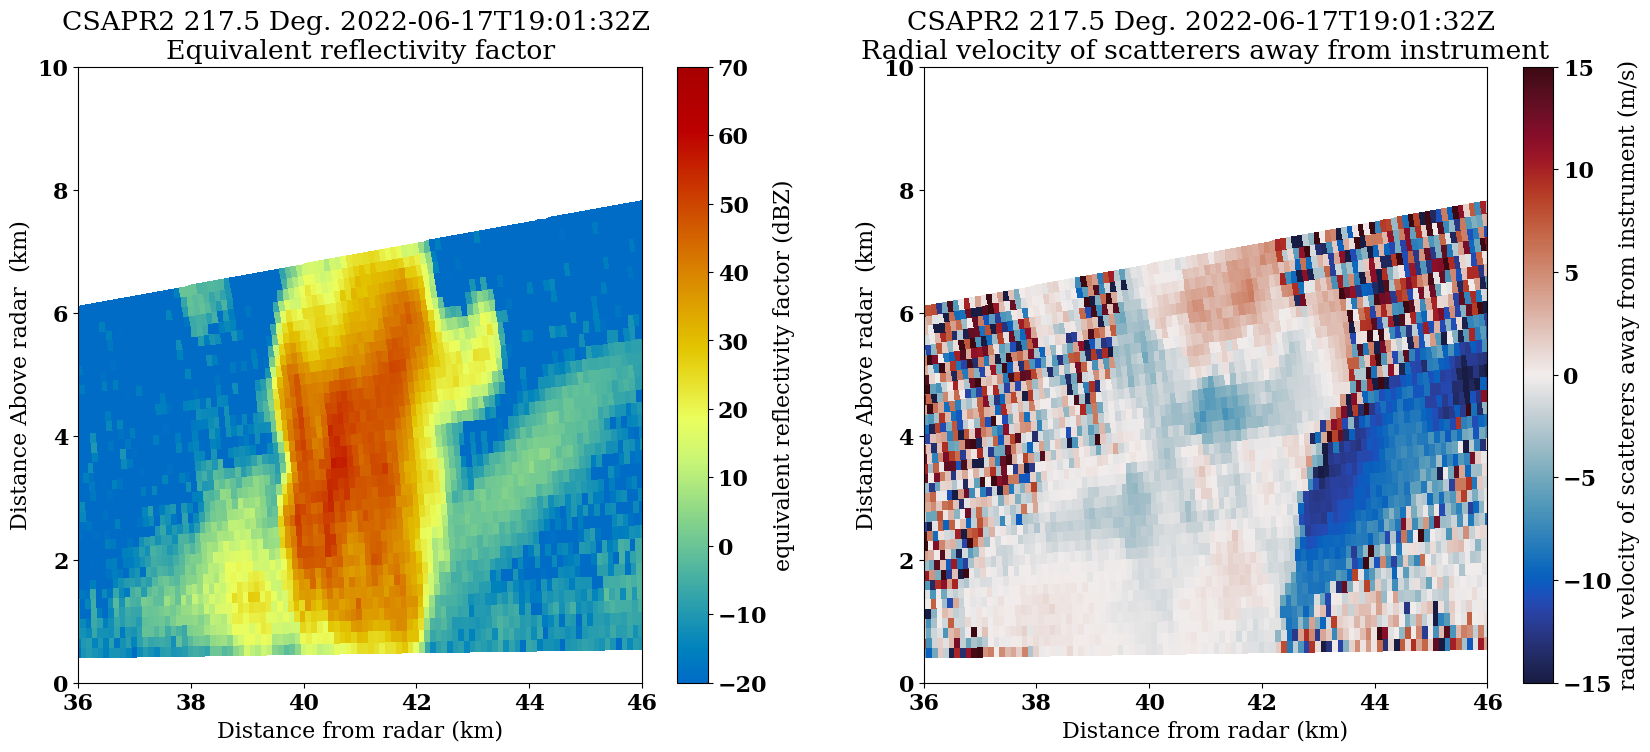

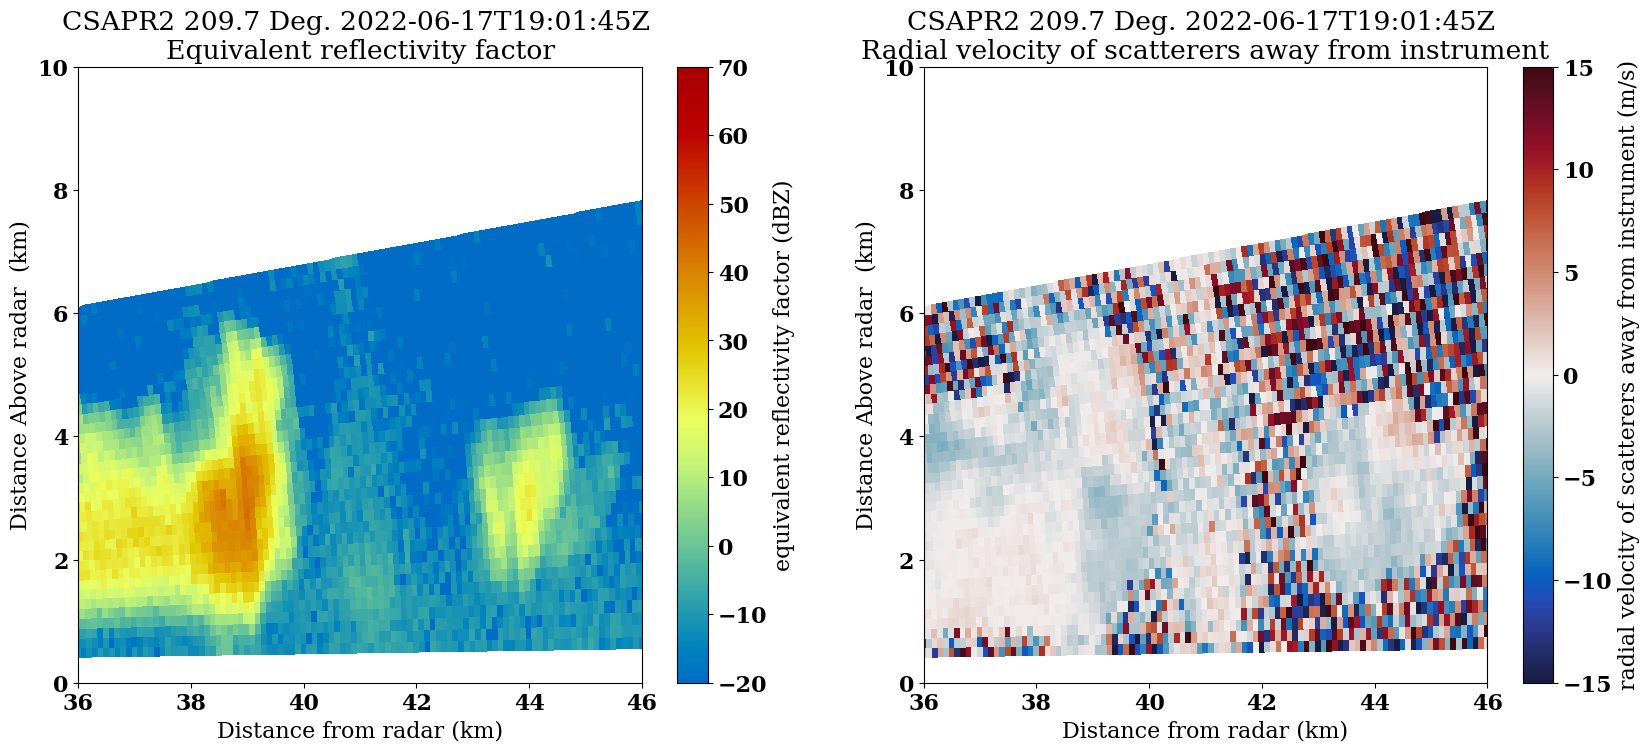

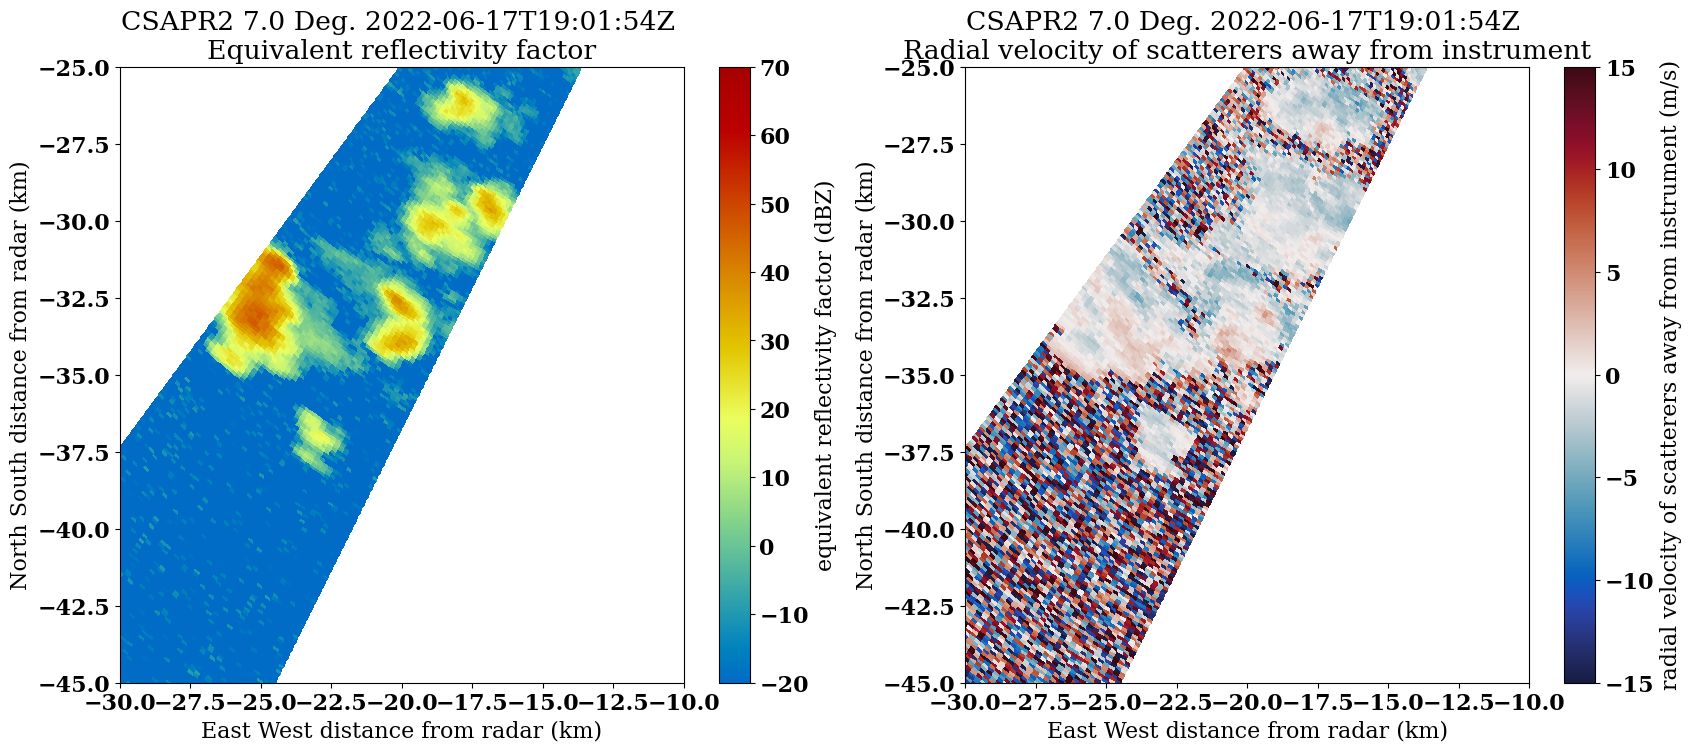

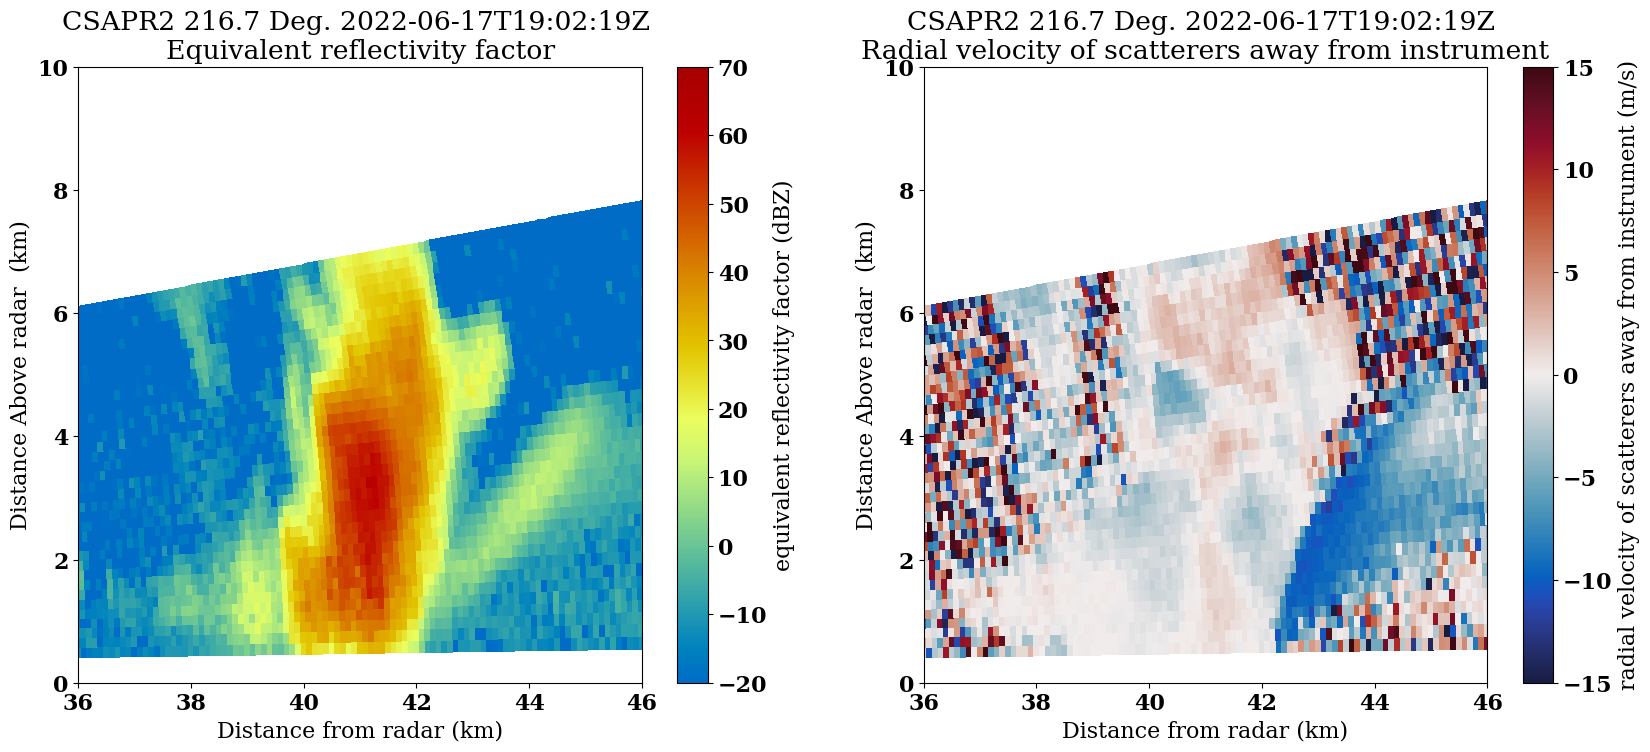

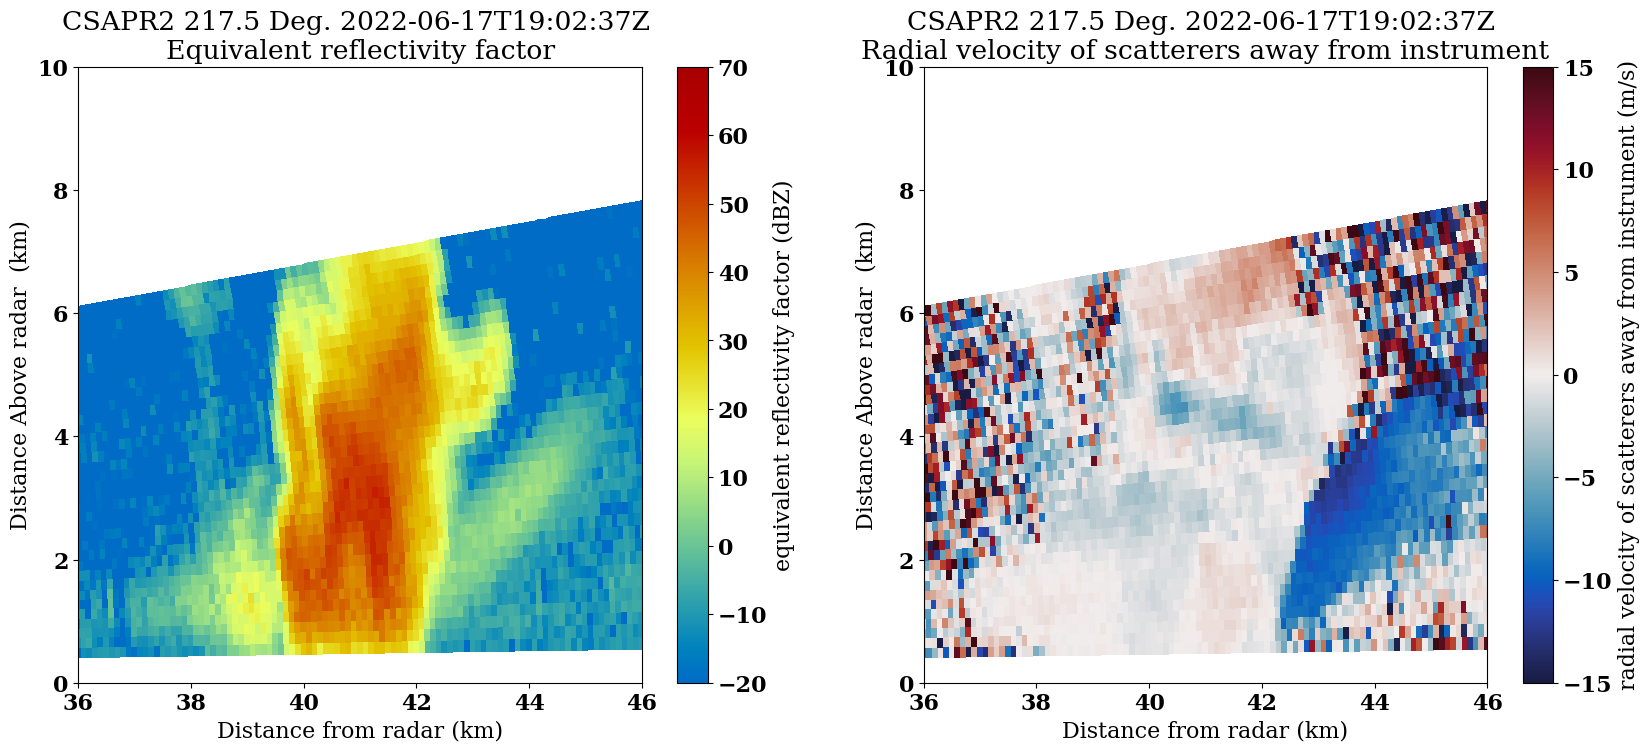

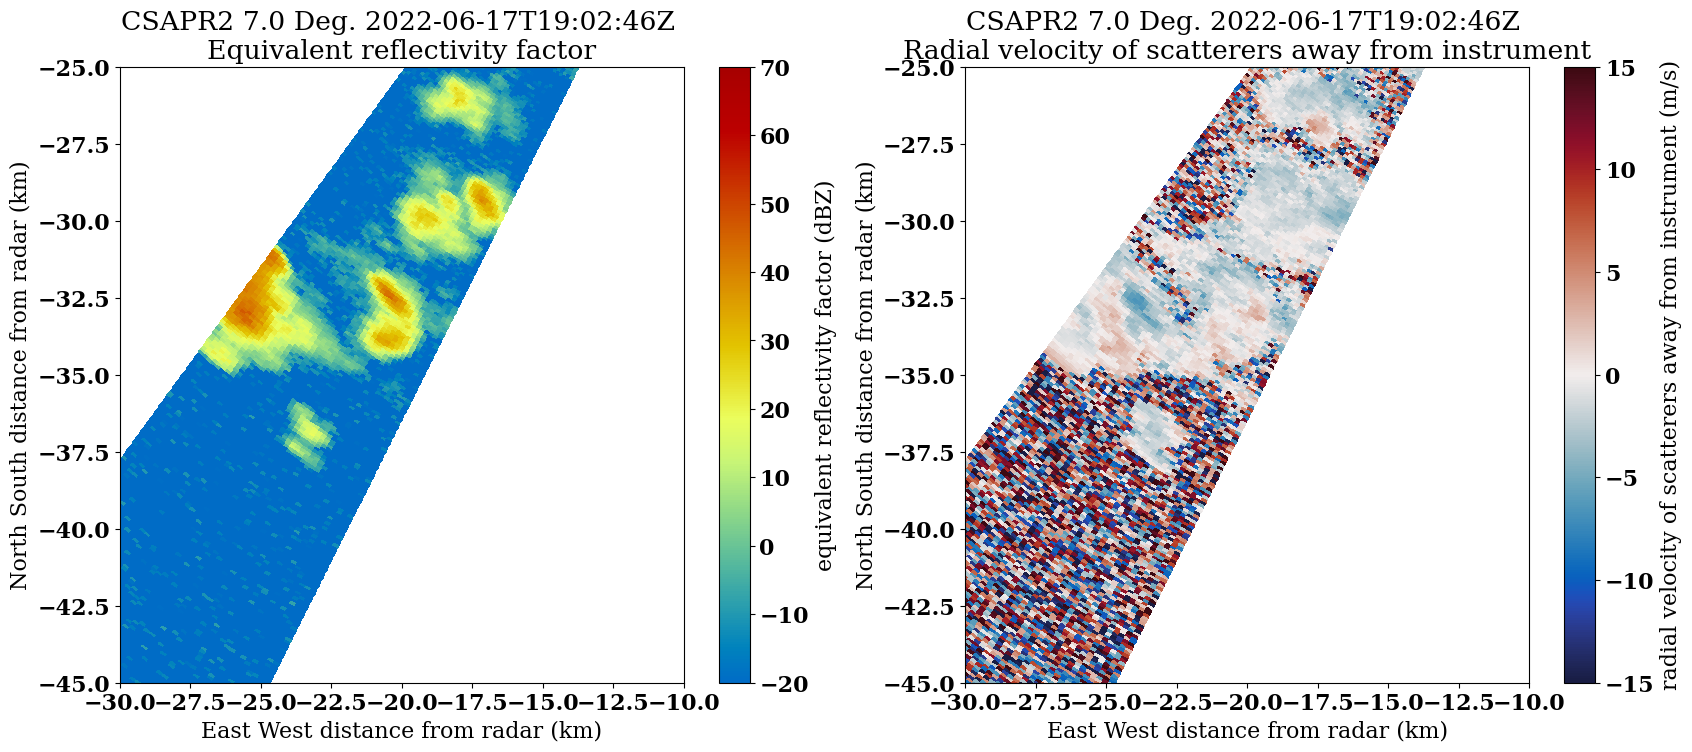

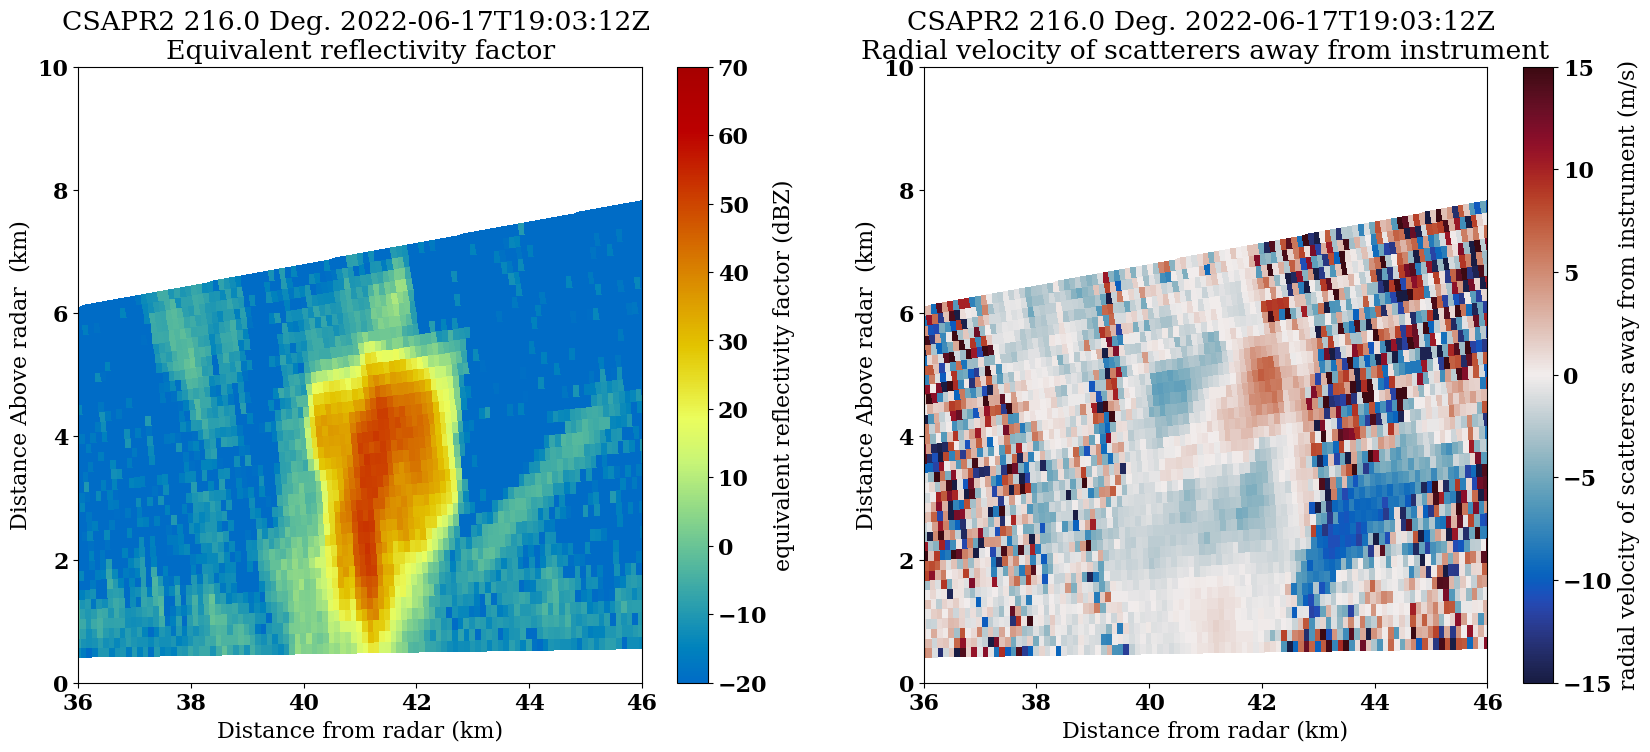

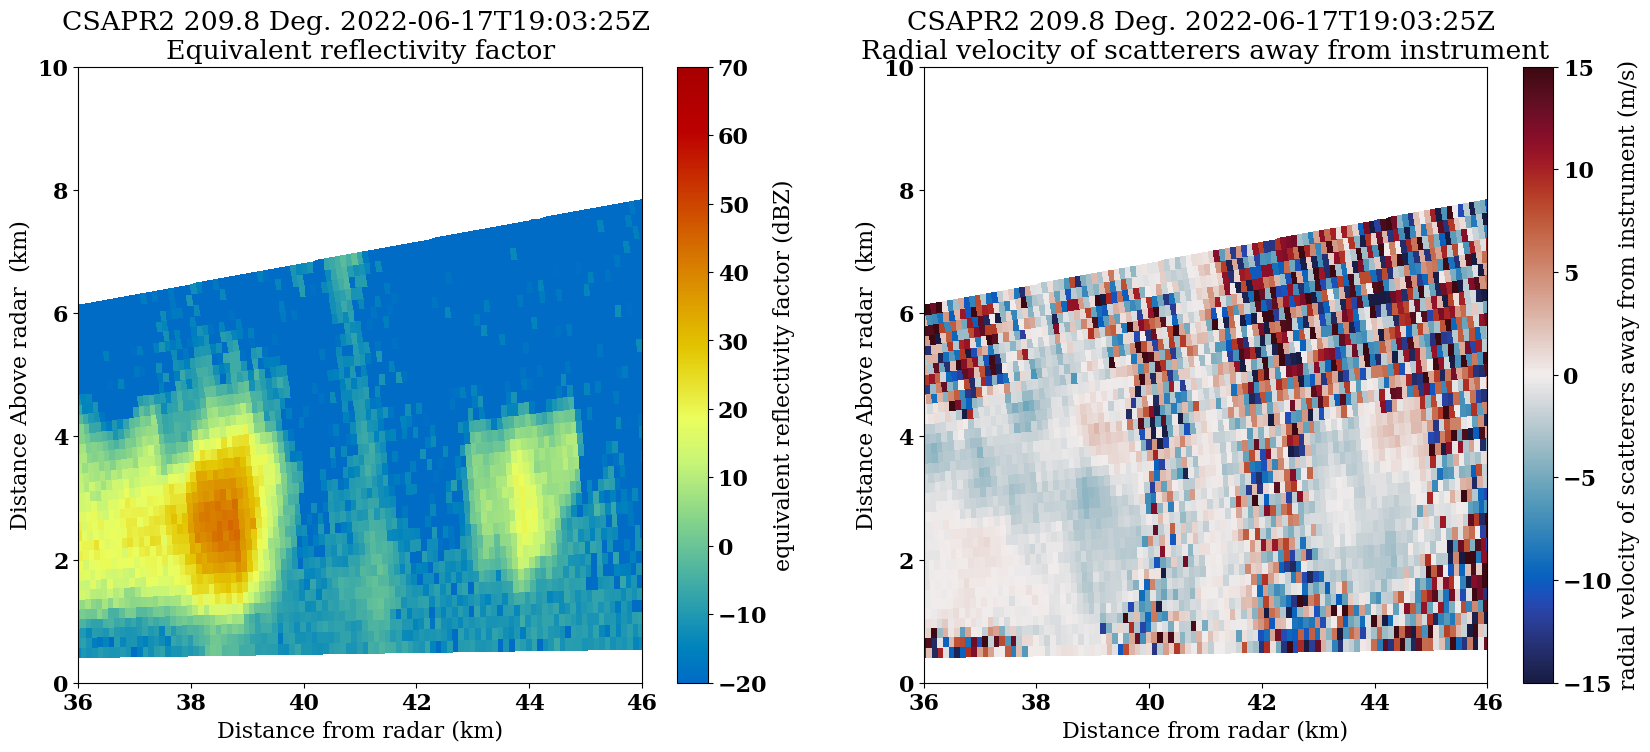

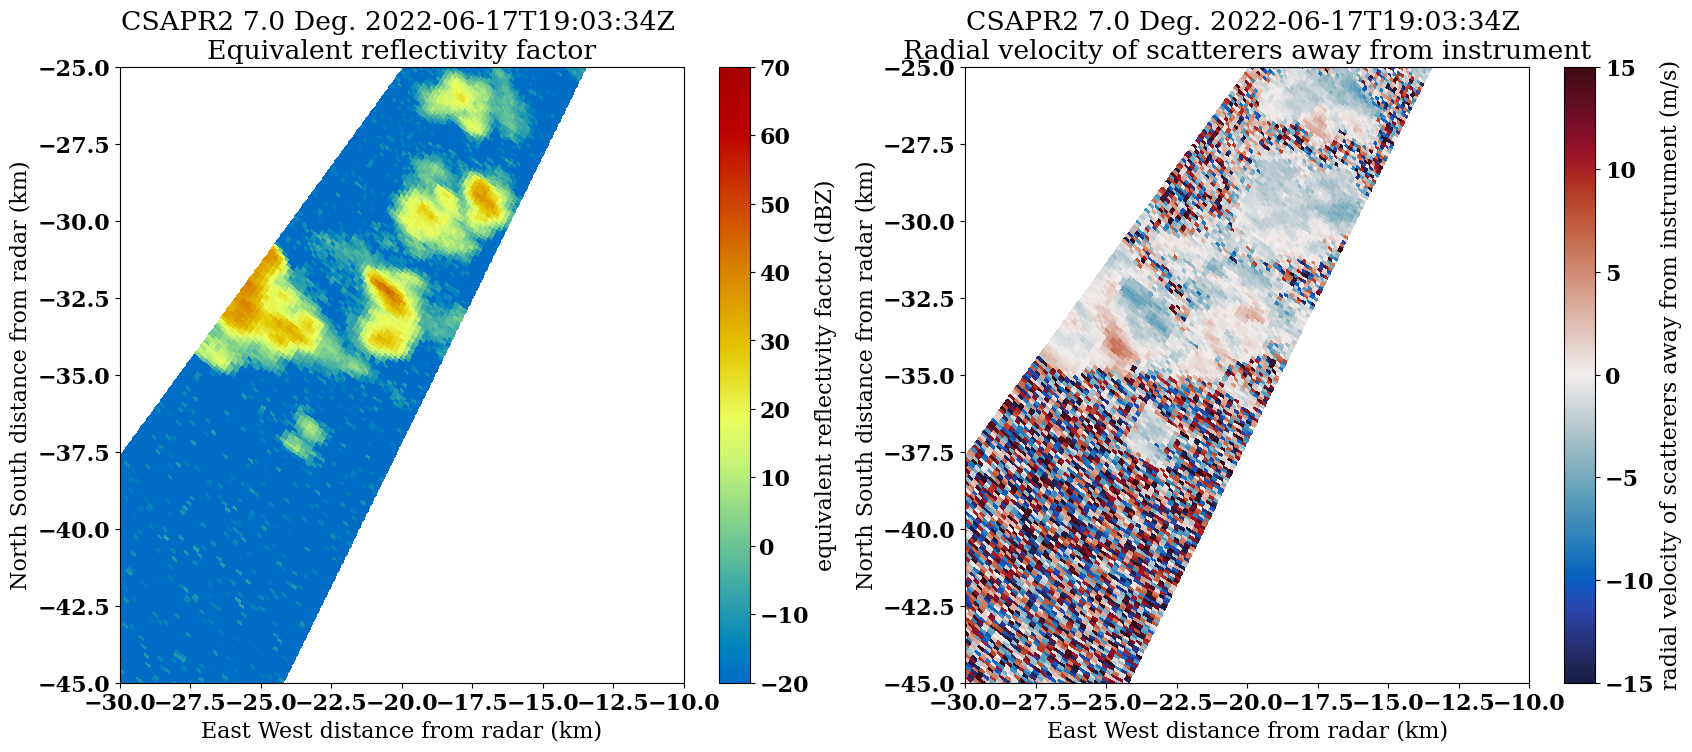

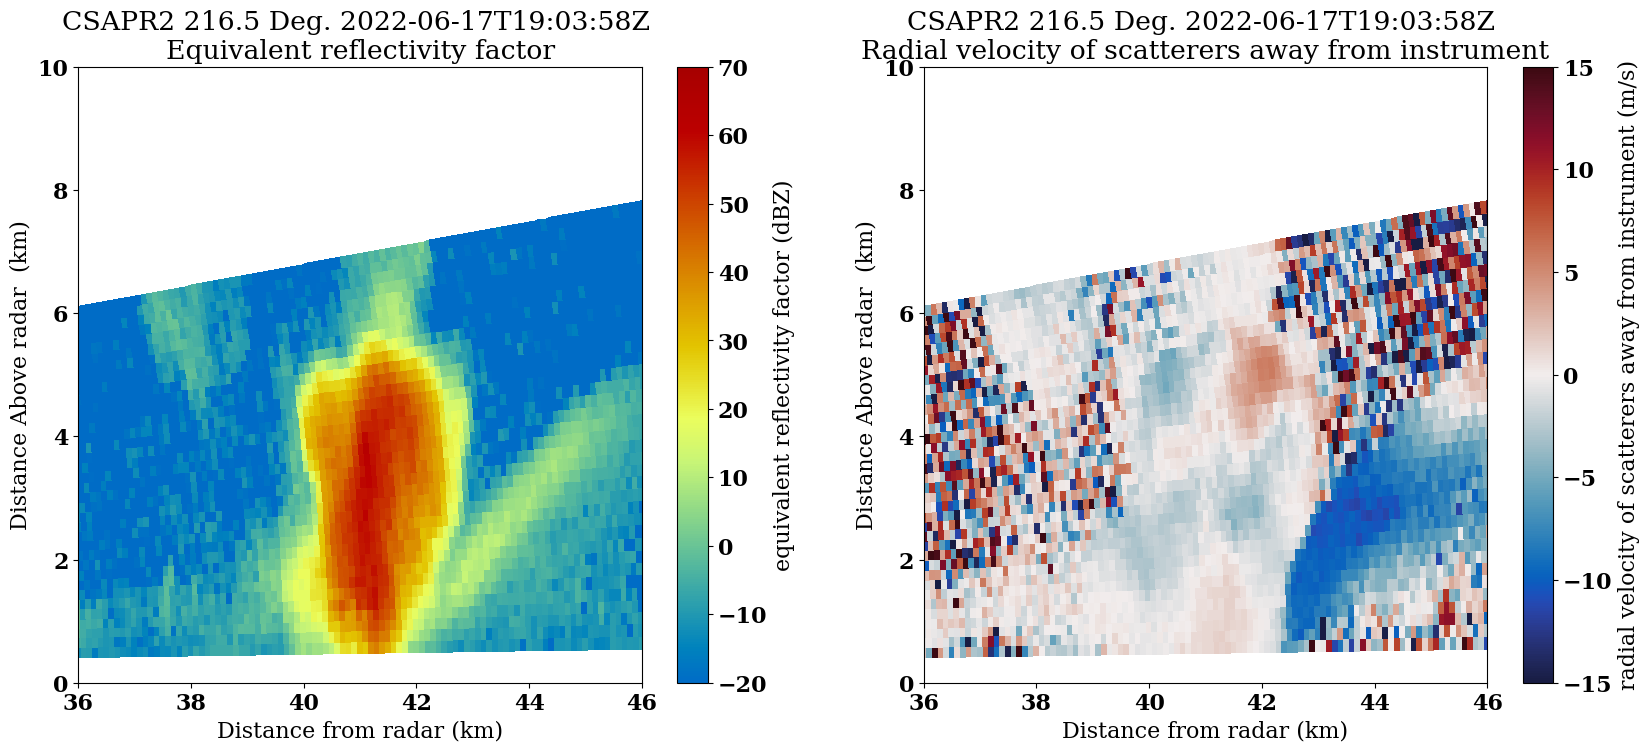

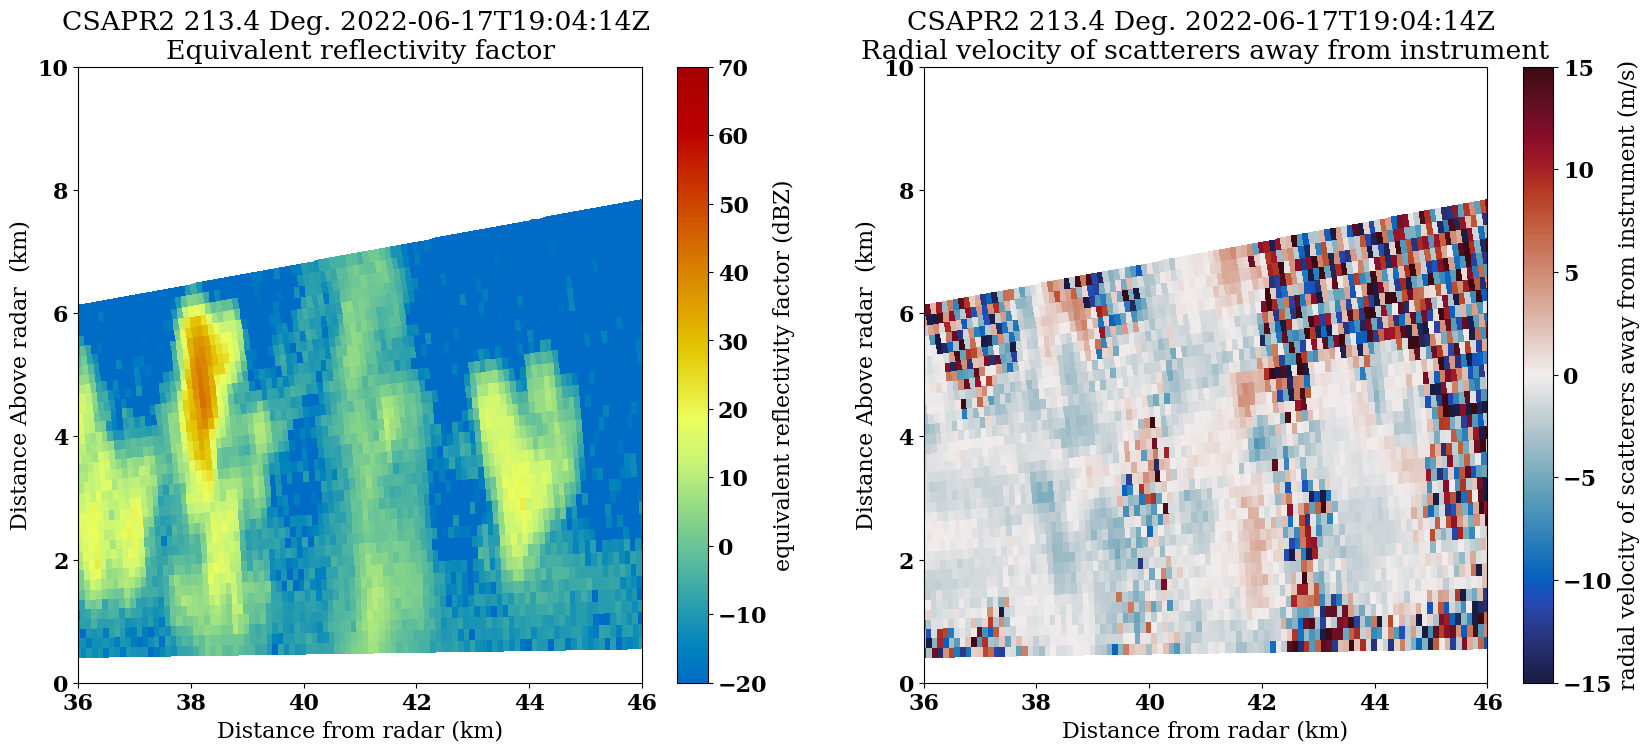

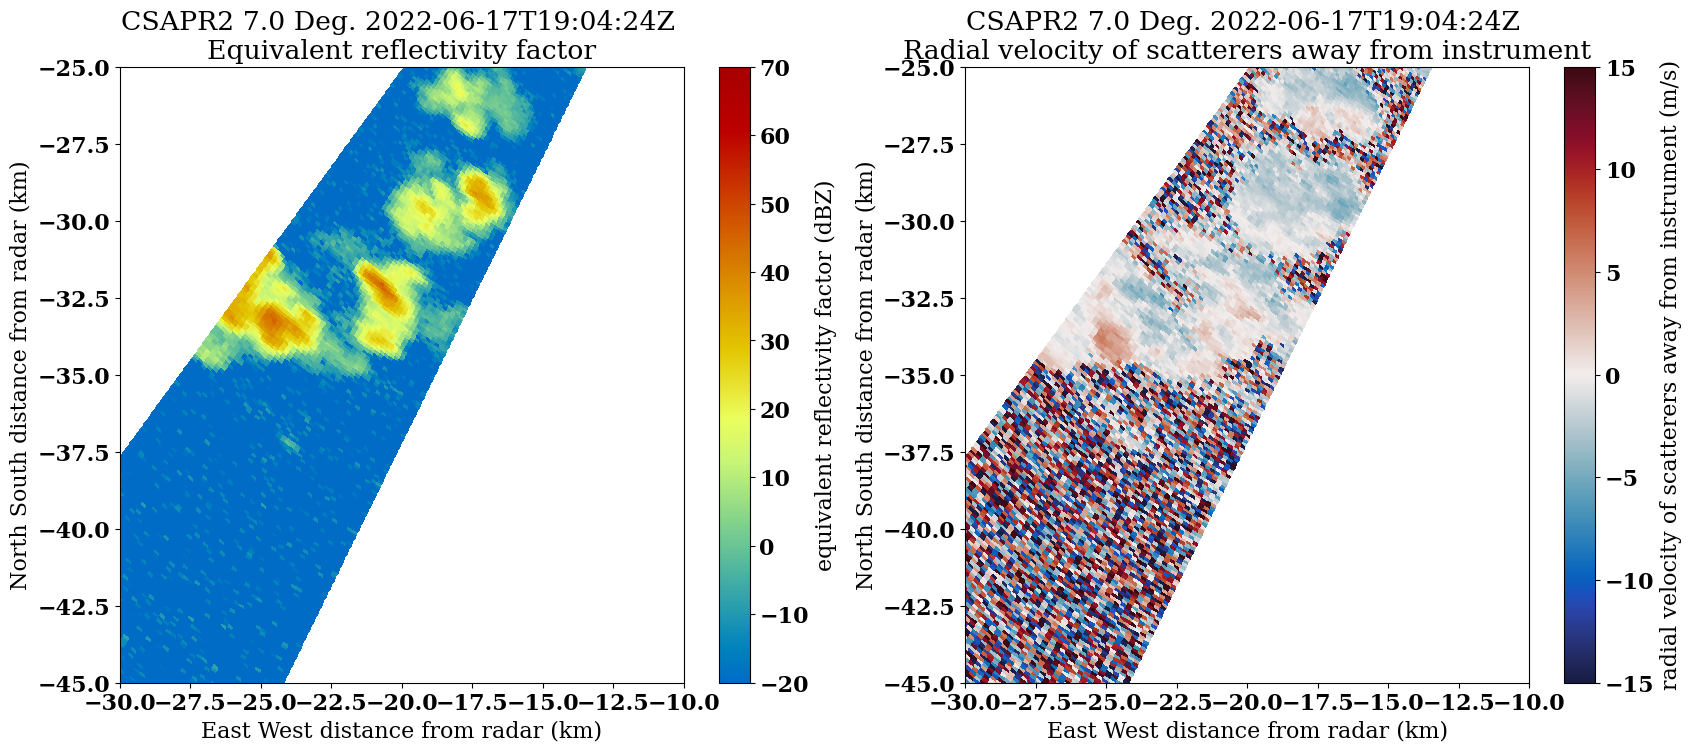

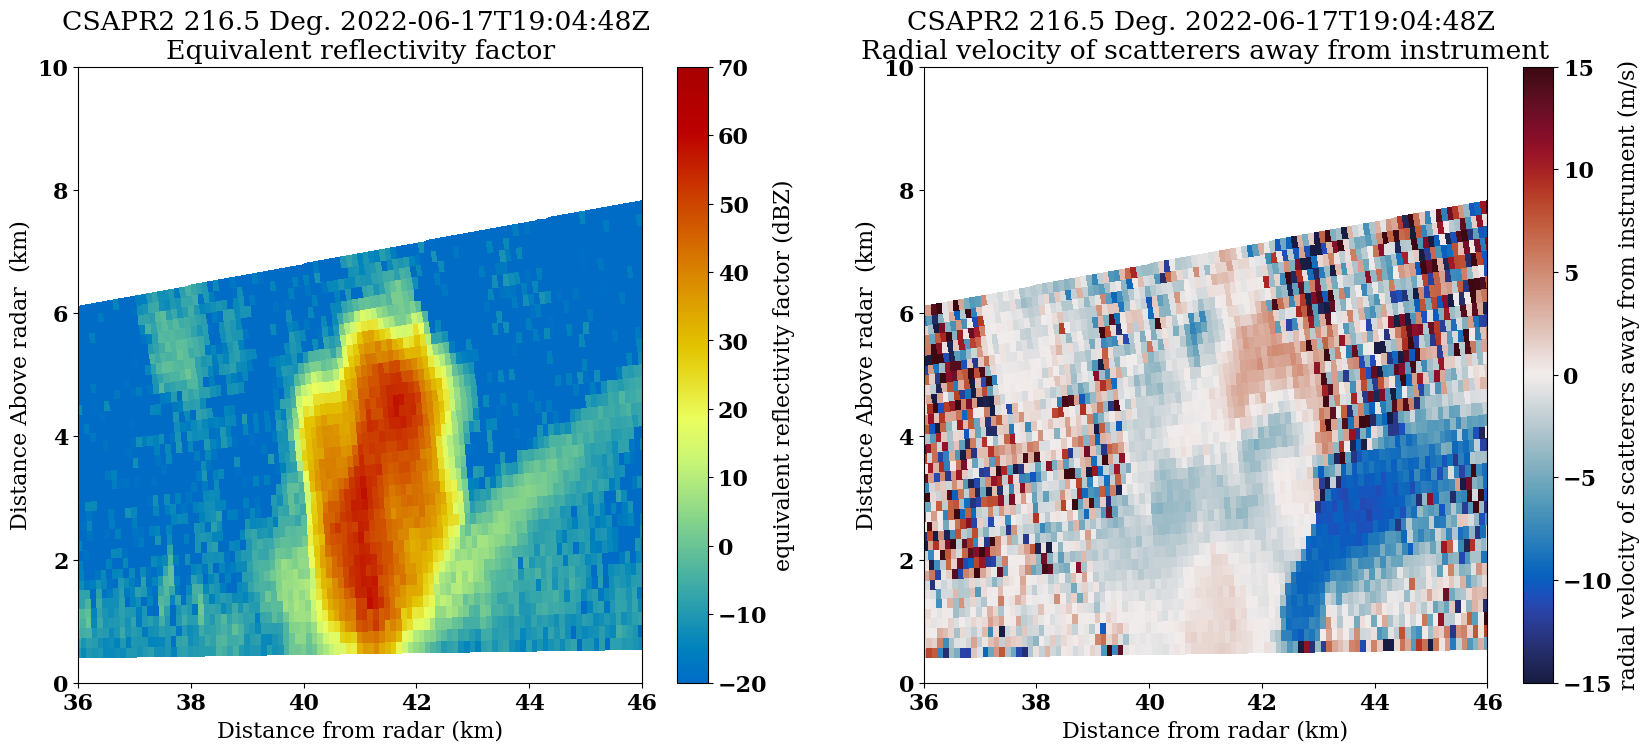

In [15]:
for file in csapr_files:
    radar = pyart.io.read(file)
    if (radar.scan_type == 'rhi' or radar.scan_type == 'ppi'):
        xlim = xlim_dict[radar.scan_type]
        ylim = ylim_dict[radar.scan_type]
        
        fig = plt.figure(figsize=(20,8))
        display = pyart.graph.RadarDisplay(radar)
        ax = plt.subplot(121)
        display.plot("reflectivity",
                     0,
                     ax=ax,
                     vmin=-20,
                     vmax=70)
        plt.xlim(xlim)
        plt.ylim(ylim)
        
        ax2 = plt.subplot(122)
        display.plot("mean_doppler_velocity",
                     0,
                     ax=ax2, 
                     cmap='pyart_balance',
                     vmin=-15,
                     vmax=15)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.savefig(f"quicklooks/{radar.scan_type}/{Path(file).stem}.png", dpi=200)
        plt.show()
        plt.close() 

### Create a GIF of teh RHI images

In [18]:
rhi_images = sorted(glob.glob("quicklooks/rhi/*"))
ppi_images = sorted(glob.glob('quicklooks/ppi/*'))

In [19]:
with imageio.get_writer('rhi-animation.gif', mode='I') as writer:
    for filename in rhi_images:
        image = imageio.imread(filename)
        writer.append_data(image)
        
with imageio.get_writer('ppi-animation.gif', mode='I') as writer:
    for filename in ppi_images:
        image = imageio.imread(filename)
        writer.append_data(image)

---
## Summary
Within this example, we walked through how to access ARM data from a field campaign in Texas, plot a quick look of the data, and refine our plots to investigate a storm!

### What's Next?
We will showcase other data workflow examples, including field campaigns in other regions and data access methods from other data centers.

## Resources and References
* [ARM Data Discovery](https://adc.arm.gov/discovery)
* [TRACER Field Campaign](https://www.arm.gov/research/campaigns/amf2021tracer)
* CSAPR Radar Data:
    - Bharadwaj, N., Collis, S., Hardin, J., Isom, B., Lindenmaier, I., Matthews, A., & Nelson, D. C-Band Scanning ARM Precipitation Radar (CSAPR2CFR). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1467901
* Py-ART:
    - Helmus, J.J. & Collis, S.M., (2016). The Python ARM Radar Toolkit (Py-ART), a Library for Working with Weather Radar Data in the Python Programming Language. Journal of Open Research Software. 4(1), p.e25. DOI: http://doi.org/10.5334/jors.119
* ACT:
    - Adam Theisen, Ken Kehoe, Zach Sherman, Bobby Jackson, Alyssa Sockol, Corey Godine, Max Grover, Jason Hemedinger, Jenni Kyrouac, Maxwell Levin, Michael Giansiracusa (2022). The Atmospheric Data Community Toolkit (ACT). Zenodo. DOI: https://doi.org/10.5281/zenodo.6712343